In [76]:
%matplotlib inline

import numpy as np 
import pandas as pd 

import os, math, random
from pathlib import Path

from tqdm import tqdm
from glob import glob
import gc

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from plotly.offline import iplot
#to link plotly to pandas
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)

plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams['axes.titlesize'] = 12
sns.set_palette('Set3')
   
from time import time, strftime, gmtime

print(os.listdir('./data/'))

start = time()
print(start)

import datetime
print(str(datetime.datetime.now()))

import warnings
warnings.simplefilter('ignore')

['Outcomes-a.txt', 'sample_submission.csv', 'set-a', 'Test.csv', 'Test_data_dictionary.csv', 'Train.csv', 'Train_data_dictionary.csv']
1648653105.7763016
2022-03-30 17:11:45.776687


In [2]:
SEED = 42
def seed_everything(seed = SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
base_dir = './data/'

In [78]:
path_file = os.path.join(base_dir, "set-a", "*.txt")
input_files = glob(path_file)
print(f"\t\t Num of training files: {len(input_files)}")

		 Num of training files: 4000


##### Outcomes.txt fields
- RecordID (defined as above)
- SAPS-I score (Le Gall et al., 1984)
- SOFA score (Ferreira et al., 2001)
- Length of stay (days)
- Survival (days)
- In-hospital death (0: survivor, or 1: died in-hospital)

In [81]:
df_target = pd.read_csv(Path(base_dir) / "Outcomes-a.txt")
print("\t\t Labels has shape: ", df_target.shape)
print(df_target.head())

		 Labels has shape:  (4000, 6)
   RecordID  SAPS-I  SOFA  Length_of_stay  Survival  In-hospital_death
0    132539       6     1               5        -1                  0
1    132540      16     8               8        -1                  0
2    132541      21    11              19        -1                  0
3    132543       7     1               9       575                  0
4    132545      17     2               4       918                  0


In [10]:
features_to_use = ["RecordID", "Age", "Gender", "Height", "Weight", "Urine", "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH", 
                   "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "ICUType"]

In [11]:
temp = pd.read_csv(np.random.choice(input_files, 1)[0])
temp.head()

,Time,Parameter,Value
0,00:00,RecordID,137427.0
1,00:00,Age,75.0
2,00:00,Gender,1.0
3,00:00,Height,175.3
4,00:00,ICUType,2.0


### Line Plots of key parameters for a single Patient

In [12]:
pid = temp[temp['Parameter'] == 'RecordID']['Value'].values[0]
target = df_target[df_target['RecordID'] == pid]['In-hospital_death'].values[0]

In [13]:
def plot_parameters(df: pd.DataFrame, pid: float, target: int):
    color = ['red', 'green', 'orange', 'blue']
    for i, p in enumerate(['RespRate', 'HR', 'Temp']):
        temp = df[['Time', 'Value']][df['Parameter'] == p]
        if not temp.empty:
            df[['Time', 'Value']][df['Parameter'] == p].iplot(kind = 'line', 
                                                               x = 'Time', 
                                                               y = 'Value', 
                                                               xTitle = 'Time',
                                                               yTitle = p,
                                                               title = f'<b>Parameter: {p}; RecordID: {pid}; Mortality: {target}</b>',
                                                               color = color[i])

In [14]:
plot_parameters(temp, pid, target)

In [15]:
def extract_to_dict(df: pd.DataFrame, features: list) -> pd.DataFrame:
    #Replace '-1' to NaNs
    df = df.replace(-1.0, np.nan)
    patient_dict = {}
    for feat in features:
        patient_dict[feat] = round(df[df['Parameter'] == feat]['Value'].mean(), 2)
    return pd.DataFrame(patient_dict, index = [0])

In [16]:
df = pd.DataFrame()

for file in tqdm(input_files):
    temp = pd.read_csv(file)
    df = df.append(extract_to_dict(temp, features_to_use))
print(df.shape)
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:49<00:00, 80.50it/s]


(4000, 21)


,RecordID,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,...,pH,PaCO2,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType
0,132539.0,54.0,0.0,NaN,NaN,171.05,70.81,37.36,50.15,NaN,...,NaN,NaN,NaN,203.00,NaN,4.20,136.50,NaN,14.92,4.0
0,132540.0,76.0,1.0,175.3,80.67,151.56,80.79,36.94,56.71,113.41,...,7.40,38.86,210.14,178.60,76.94,3.90,137.00,0.56,13.33,2.0
0,132541.0,44.0,0.0,NaN,56.70,124.95,83.76,37.80,79.00,125.69,...,7.49,35.50,134.50,89.67,90.44,4.26,138.33,0.50,5.92,3.0
0,132543.0,68.0,1.0,180.3,84.60,545.83,70.98,36.22,65.05,NaN,...,NaN,NaN,NaN,330.00,NaN,4.00,139.33,NaN,14.94,3.0
0,132545.0,88.0,0.0,NaN,NaN,62.13,74.96,36.88,45.72,NaN,...,NaN,NaN,NaN,103.00,NaN,4.32,139.50,NaN,15.00,3.0


##### Merge train features with target

In [17]:
#we just need the In-hospital_death from the target df
df = df.merge(df_target[['RecordID', 'In-hospital_death']], on = 'RecordID')
df.shape

(4000, 22)

In [18]:
#Save
df.to_csv('./icu_mortality_train.csv', index = False)
df.head()

,RecordID,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,...,PaCO2,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType,In-hospital_death
0,132539.0,54.0,0.0,NaN,NaN,171.05,70.81,37.36,50.15,NaN,...,NaN,NaN,203.00,NaN,4.20,136.50,NaN,14.92,4.0,0
1,132540.0,76.0,1.0,175.3,80.67,151.56,80.79,36.94,56.71,113.41,...,38.86,210.14,178.60,76.94,3.90,137.00,0.56,13.33,2.0,0
2,132541.0,44.0,0.0,NaN,56.70,124.95,83.76,37.80,79.00,125.69,...,35.50,134.50,89.67,90.44,4.26,138.33,0.50,5.92,3.0,0
3,132543.0,68.0,1.0,180.3,84.60,545.83,70.98,36.22,65.05,NaN,...,NaN,NaN,330.00,NaN,4.00,139.33,NaN,14.94,3.0,0
4,132545.0,88.0,0.0,NaN,NaN,62.13,74.96,36.88,45.72,NaN,...,NaN,NaN,103.00,NaN,4.32,139.50,NaN,15.00,3.0,0


In [19]:
# -1 is data unavailable, we convert them to NaNs
df = df.replace([-1.0, np.inf, -np.inf], np.nan)

In [23]:
df.columns

Index(['RecordID', 'Age', 'Gender', 'Height', 'Weight', 'Urine', 'HR', 'Temp',
       'NIDiasABP', 'SysABP', 'DiasABP', 'pH', 'PaCO2', 'PaO2', 'Platelets',
       'MAP', 'K', 'Na', 'FiO2', 'GCS', 'ICUType', 'In-hospital_death'],
      dtype='object')

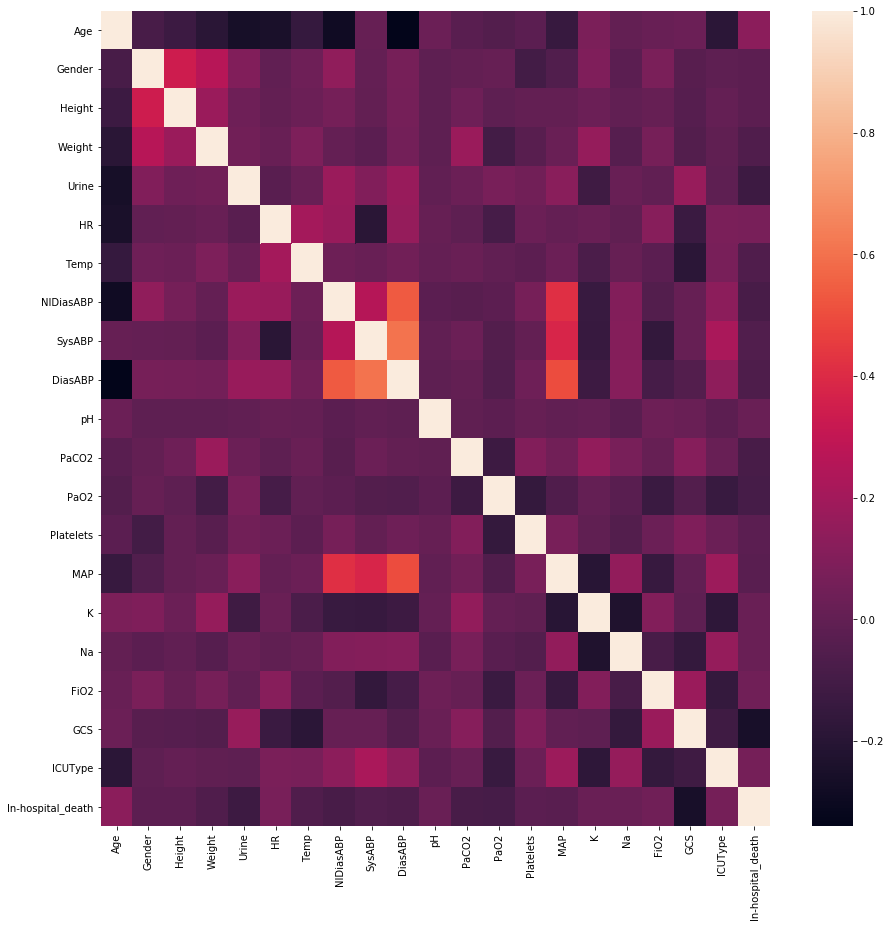

In [25]:
df_copy = df.drop("RecordID", axis=1)
corr = df_copy.corr()

# plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, xticklabels = corr.columns,  yticklabels=corr.columns)

# Explotory Data Analysis

In [20]:
# Missing values plot
missing = df.isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / len(df)) * 100
missing.index = missing['features']
del missing['features']

missing['total_missing'].iplot(kind = 'bar', 
                               title = f'<b>Missing Values Count in Dataset</b>',
                               xTitle = 'Features',
                               colors = 'blue',
                               yTitle = 'Count')
missing.T

features,RecordID,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,...,PaCO2,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType,In-hospital_death
total_missing,0.0,0.0,3.000,1894.00,296.0,117.000,63.000,64.0,517.000,1201.000,...,977.000,977.000,68.0,1208.0,96.0,75.000,1283.000,64.0,0.0,0.0
percent,0.0,0.0,0.075,47.35,7.4,2.925,1.575,1.6,12.925,30.025,...,24.425,24.425,1.7,30.2,2.4,1.875,32.075,1.6,0.0,0.0


##### Lets check the target distribution

In [26]:
df['In-hospital_death'].value_counts()

0    3446
1     554
Name: In-hospital_death, dtype: int64

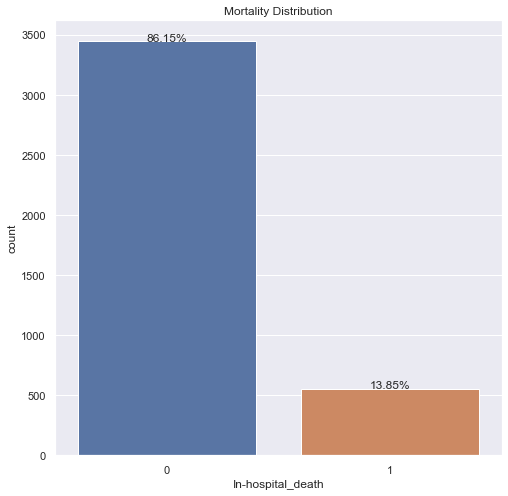

In [37]:
plt.figure(figsize = (8, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(df['In-hospital_death'])
plt.title('Mortality Distribution')
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')

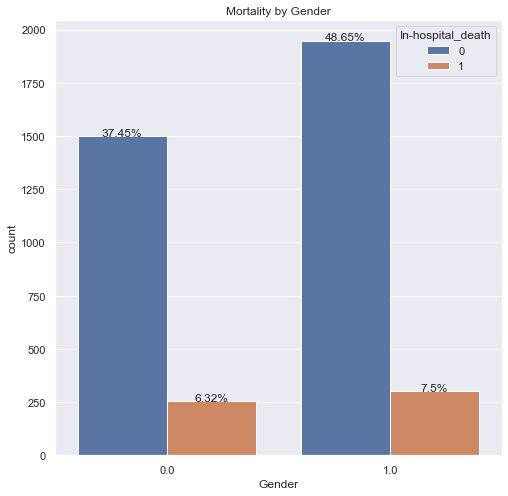

In [38]:
plt.figure(figsize = (8, 8))
sns.set_theme(style="darkgrid")
plt.title('Mortality by Gender')
ax = sns.countplot(x = 'Gender', data = df, hue = 'In-hospital_death')
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')

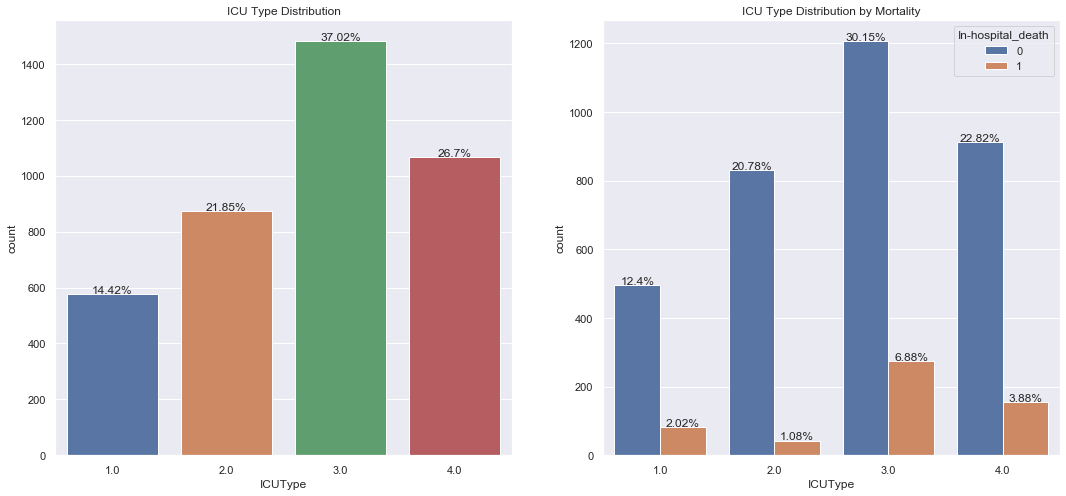

In [39]:
plt.figure(figsize = (18, 8))
plt.subplot(1, 2, 1)
sns.set_theme(style="darkgrid")
plt.title('ICU Type Distribution')
ax = sns.countplot(x = 'ICUType', data = df)
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')
        
plt.subplot(1, 2, 2)
plt.title('ICU Type Distribution by Mortality')
ax = sns.countplot(x = 'ICUType', data = df, hue = 'In-hospital_death')
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')

**Comment:**
> - We notice that mortality is higher in patients in ICUType 

#### Mortality by age group

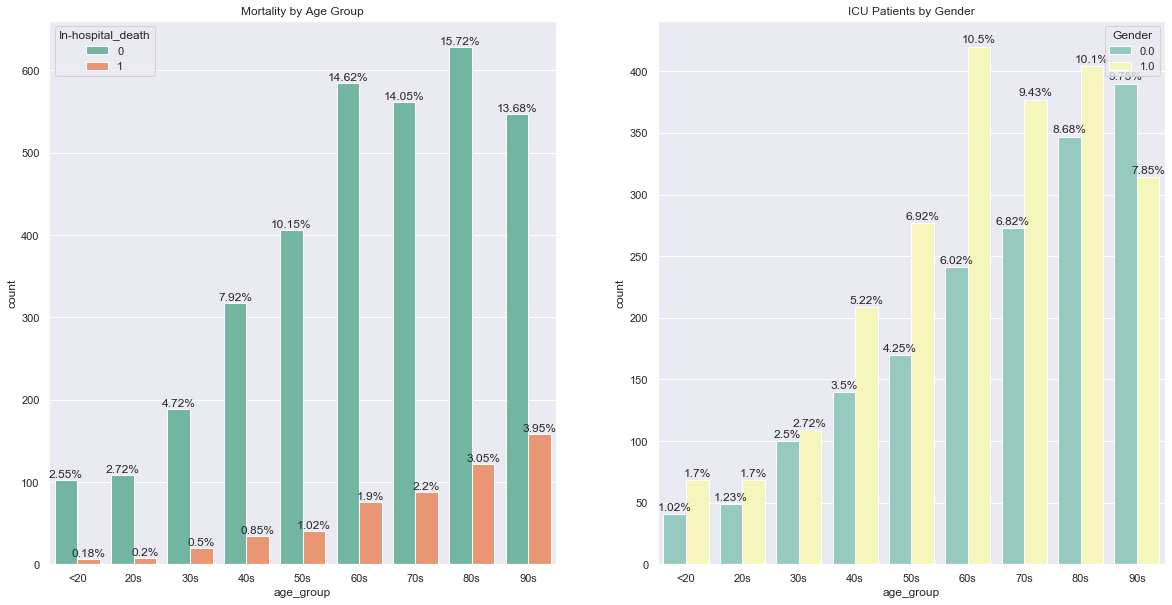

In [40]:
df['age_group'] = pd.cut(df['Age'], bins = 9, labels = ['<20', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'])

plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
sns.set_theme(style="darkgrid")
plt.title('Mortality by Age Group')
ax = sns.countplot(x = 'age_group', data = df, hue = 'In-hospital_death', palette = 'Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

plt.subplot(1, 2, 2)
plt.title('ICU Patients by Gender')
ax = sns.countplot(x = 'age_group', data = df, hue = 'Gender', palette = 'Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

**Comment:**
>- Mortality is more for patients in higher age group
>- More Male patients are in ICU than Female patients

### Outliers detection

In [42]:
cat_features = ['Gender', 'ICUType', 'age_group', 'bmi_group']
num_features = [c for c in df.columns if c not in cat_features]
num_features = [c for c in num_features if c not in ['RecordID', 'In-hospital_death']]

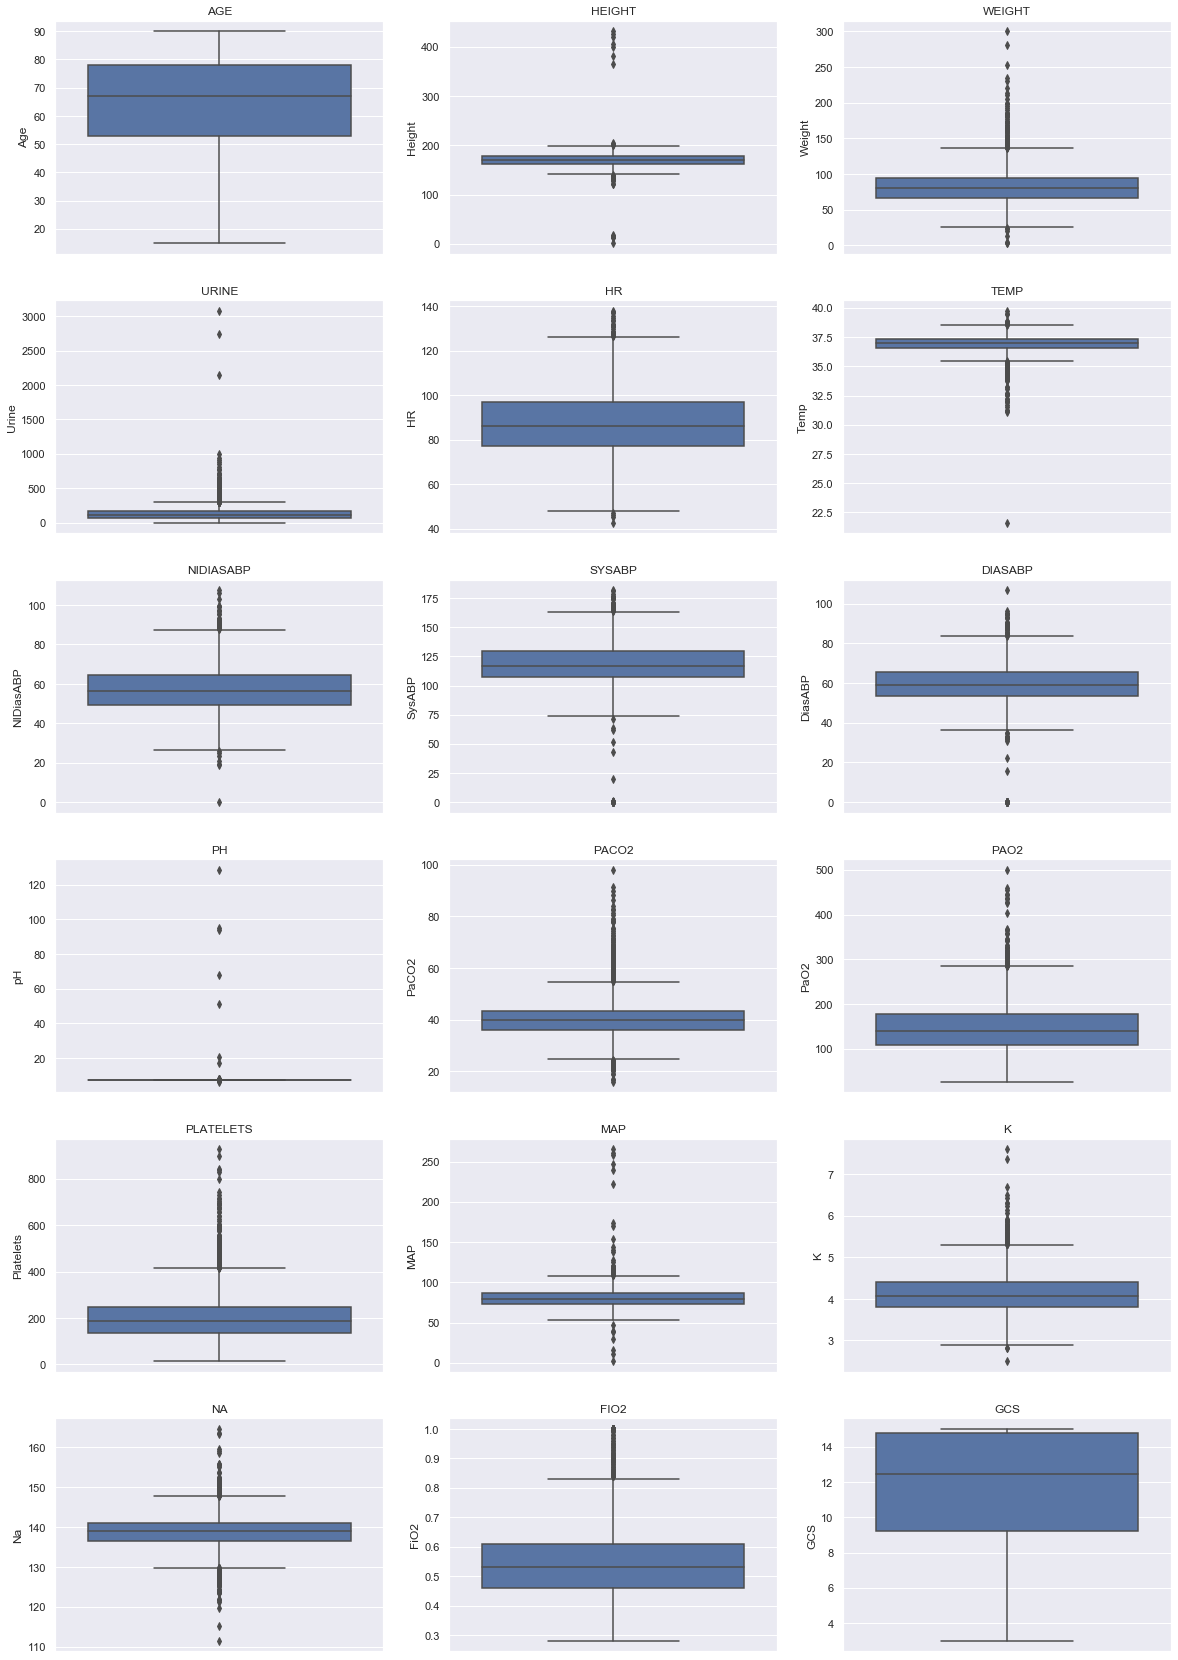

In [43]:
plt.figure(figsize = (20, 30))
sns.set_theme(style="darkgrid")
for i, col in enumerate(df[num_features]):
    plt.subplot(6, len(num_features) / 6, i + 1)
    sns.boxplot(y = col, data = df)
    plt.title(col.upper())
    

**Comment:**
>- We observe that allmost all features have outliers